<a href="https://colab.research.google.com/github/ben-hayes/neural-waveshaping-synthesis/blob/main/colab/NEWT_Timbre_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">neural waveshaping synthesis</h1>
<h4 align="center">real-time neural audio synthesis in the waveform domain</h4>

<div align="center">
<h4>
    <a href="https://benhayes.net/assets/pdf/nws_arxiv.pdf" target="_blank">paper</a> •
        <a href="https://benhayes.net/projects/nws/" target="_blank">website</a> • 
        <a href="https://github.com/ben-hayes/neural-waveshaping-synthesis/" target="_blank">github</a> • 
        <a href="https://benhayes.net/projects/nws/#audio-examples">audio</a>
    </h4>
    <p>
    by <em>Ben Hayes, Charalampos Saitis, György Fazekas</em>
    </p>
</div>

<p>
This Google Colab notebook is a supplement to our ISMIR 2021 paper, <i>Neural Waveshaping Synthesis</i>.
By running the code in the following cells, you can use one of our pretrained models to perform timbre transfer from any monophonic audio to flute, trumpet, or violin!
</p>

<p align="center"><img src="https://benhayes.net/assets/img/newt_shapers.png" /></p>



# Setup

In [14]:
%%capture
#@title Install dependencies
#@markdown 
!rm -rf neural-waveshaping-synthesis
!git clone https://github.com/ben-hayes/neural-waveshaping-synthesis.git
%cd neural-waveshaping-synthesis
!pip install youtube-dl pytorch-lightning auraloss==0.2.1 librosa==0.8.0 torchcrepe==0.0.12 wandb
!pip install -q https://github.com/tugstugi/dl-colab-notebooks/archive/colab_utils.zip
!pip install -e .

In [8]:
%%capture
#@title Make imports

import os
import time
import warnings
warnings.filterwarnings("ignore")

from dl_colab_notebooks.audio import record_audio
import gin
from google.colab import files
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import torch

from neural_waveshaping_synthesis.data.utils.loudness_extraction import extract_perceptual_loudness
from neural_waveshaping_synthesis.data.utils.mfcc_extraction import extract_mfcc
from neural_waveshaping_synthesis.data.utils.f0_extraction import extract_f0_with_crepe
from neural_waveshaping_synthesis.data.utils.preprocess_audio import preprocess_audio, convert_to_float32_audio, make_monophonic, resample_audio
from neural_waveshaping_synthesis.models.neural_waveshaping import NeuralWaveshaping

try:
  gin.constant("device", "cuda")
except ValueError as err:
  pass
gin.parse_config_file("gin/models/newt.gin")
gin.parse_config_file("gin/data/urmp_4second_crepe.gin")
device = torch.device("cuda")

checkpoints = dict(Violin="vn", Flute="fl", Trumpet="tpt")

In [16]:
%%capture
#@title Load Checkpoint { run: "auto" }
#@markdown Choose from one of three pretrained checkpoints. In future you will be able to upload your own checkpoints too.
selected_checkpoint_name = "Violin" #@param ["Violin", "Flute", "Trumpet"]
selected_checkpoint = checkpoints[selected_checkpoint_name]

checkpoint_path = os.path.join(
    "checkpoints/nws", selected_checkpoint)
model = NeuralWaveshaping.load_from_checkpoint(
    os.path.join(checkpoint_path, "last.ckpt")).to(device)
model.eval()
data_mean = np.load(
    os.path.join(checkpoint_path, "data_mean.npy"))
data_std = np.load(
    os.path.join(checkpoint_path, "data_std.npy"))

# Audio Input

You now have a few options for getting source audio into the model.
Whichever you choose, monophonic audio will give you best results. Polyphony is likely to result in chaos.

You only need to run one of these cells. Whichever one you ran last will be used as the model input. When you're done, jump down to **Prepare Audio** below.

To start with, why not jump in with the pre-populated YouTube URL?

In [15]:
#@title 1. Get Audio from YouTube

#@markdown It's hard to beat the default video link...

youtube_url = "https://www.youtube.com/watch?v=dYvPCgcFDIo" #@param {type: "string"}
start_in_seconds = 6.5 #@param {type: "number"}
length_in_seconds = 20.0 #@param {type: "number"}

!rm *.wav
!youtube-dl --extract-audio --audio-format wav {youtube_url} #-o yt_audio.wav
!mv *.wav yt_audio.wav

rate, audio = wavfile.read("yt_audio.wav")
audio = convert_to_float32_audio(make_monophonic(audio))
audio = audio[int(rate * start_in_seconds):int(rate * (start_in_seconds + length_in_seconds))]
audio = resample_audio(audio, rate, model.sample_rate)
ipd.Audio(audio, rate=model.sample_rate)

OR

In [ ]:
#@title 2. Upload an audio file
#@markdown For now, only .wav files are supported.

!rm -rf *.wav
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

rate, audio = wavfile.read(file_name)
audio = convert_to_float32_audio(make_monophonic(audio))
audio = resample_audio(audio, rate, model.sample_rate)
ipd.Audio(audio, rate=model.sample_rate)

OR

In [ ]:
#@title 3. Record audio
#@markdown Try singing or whistling into the microphone and becoming an instrument yourself!

record_seconds = 10 #@param {type: "number"}
audio = record_audio(record_seconds, sample_rate=model.sample_rate)
ipd.Audio(audio, rate=model.sample_rate)

# Prepare Audio

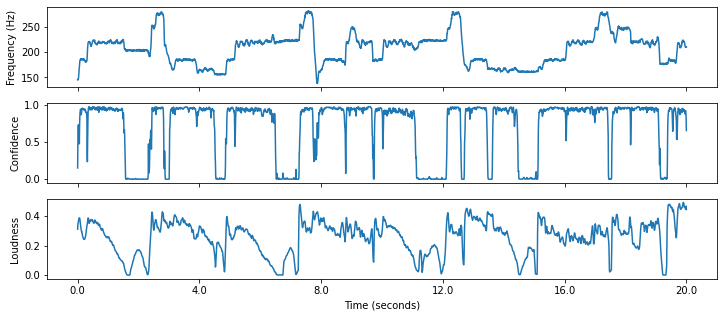

In [11]:
#@title Extract Audio Features
#@markdown Here we extract F0 using CREPE and A-weighted loudness.

use_full_crepe_model = True #@param {type: "boolean"}
with torch.no_grad():
  f0, confidence = extract_f0_with_crepe(
      audio,
      full_model=use_full_crepe_model,
      maximum_frequency=1000)
  loudness = extract_perceptual_loudness(audio)

fig, axs = plt.subplots(3, 1, True, False, figsize=(12, 5))
axs[0].plot(f0)
# axs[0].set_title("F0")
axs[0].set_ylabel("Frequency (Hz)")
axs[1].plot(confidence)
# axs[1].set_title("Pitch Confidence")
axs[1].set_ylabel("Confidence")
axs[2].plot(loudness)
axs[2].set_ylabel("Loudness")

axs[2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: (x * model.control_hop / model.sample_rate)))
axs[2].set_xlabel("Time (seconds)")

plt.show()

  

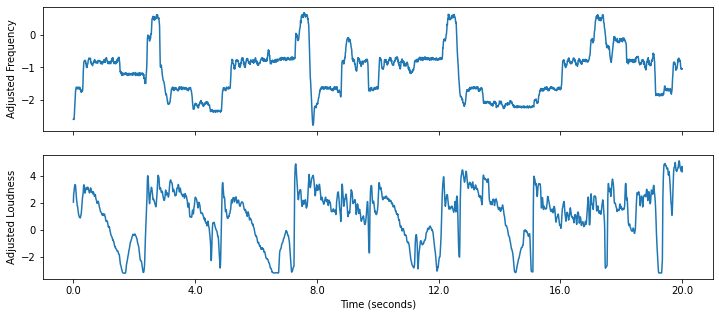

In [12]:
#@title Adjust Control Signals { run: "auto" }
#@markdown Our source audio might not quite match the characteristics of the training audio, so let's adjust it to fit

#@markdown Play with these parameters to shift pitch and loudness into an appropriate range:
octave_shift = 1 #@param {type: "slider", min: -4, max: 4, step: 1}
loudness_scale = 0.5 #@param {type: "slider", min: 0, max: 2, step: 0.01}

#@markdown ---
#@markdown These parameters are slightly more experimental:
loudness_floor = 0 #@param {type: "slider", min: 0, max: 1, step: 0.01}
loudness_conf_filter = 0 #@param {type: "slider", min: 0, max: 0.5, step: 0.001}
pitch_conf_filter = 0 #@param {type: "slider", min: 0, max: 0.5, step: 0.001}

#@markdown ---
#@markdown These parameters are very experimental but can make some fun wacky sounds:
pitch_smoothing = 0 #@param {type: "slider", min: 0, max: 100}
loudness_smoothing = 0 #@param {type: "slider", min: 0, max: 100}

with torch.no_grad():
  f0_filtered = f0 * (confidence > pitch_conf_filter)
  loudness_filtered = loudness * (confidence > loudness_conf_filter)
  f0_shifted = f0_filtered * (2 ** octave_shift)
  loudness_floored = loudness_filtered * (loudness_filtered > loudness_floor) - loudness_floor
  loudness_scaled = loudness_floored * loudness_scale
  # loudness = loudness * (confidence > 0.4)
  
  loud_norm = (loudness_scaled - data_mean[1]) / data_std[1]
  
  f0_t = torch.tensor(f0_shifted, device=device).float()
  loud_norm_t = torch.tensor(loud_norm, device=device).float()

  if pitch_smoothing != 0:
    f0_t = torch.nn.functional.conv1d(
      f0_t.expand(1, 1, -1),
      torch.ones(1, 1, pitch_smoothing * 2 + 1, device=device) /
        (pitch_smoothing * 2 + 1),
      padding=pitch_smoothing
    ).squeeze()
  f0_norm_t = torch.tensor((f0_t.cpu() - data_mean[0]) / data_std[0], device=device).float()

  if loudness_smoothing != 0:
    loud_norm_t = torch.nn.functional.conv1d(
      loud_norm_t.expand(1, 1, -1),
      torch.ones(1, 1, loudness_smoothing * 2 + 1, device=device) /
        (loudness_smoothing * 2 + 1),
      padding=loudness_smoothing
    ).squeeze()
  f0_norm_t = torch.tensor((f0_t.cpu() - data_mean[0]) / data_std[0], device=device).float()
  
  control = torch.stack((f0_norm_t, loud_norm_t), dim=0)

fig, axs = plt.subplots(2, 1, True, False, figsize=(12, 5))
axs[0].plot(f0_norm_t.cpu())
# axs[0].set_title("F0")
axs[0].set_ylabel("Adjusted Frequency")
axs[1].plot(loud_norm_t.cpu())
axs[1].set_ylabel("Adjusted Loudness")

axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: (x * model.control_hop / model.sample_rate)))
axs[1].set_xlabel("Time (seconds)")

plt.show()

# Generation Time

In [13]:
#@title Synthesise Audio!
#@markdown Finally, run this cell to get some audio from the model.
with torch.no_grad():
  start_time = time.time()
  out = model(f0_t.expand(1, 1, -1), control.unsqueeze(0))
  run_time = time.time() - start_time
rtf = (audio.shape[-1] / model.sample_rate) / run_time
print("Audio generated in %.2f seconds. That's %.1f times faster than the real time threshold!" % (run_time, rtf))
ipd.Audio(out.detach().cpu().numpy(), rate=model.sample_rate)

Audio generated in 0.17 seconds. That's 119.5 times faster than the real time threshold!
